<a href="https://colab.research.google.com/github/Livy-Li/Twitter_Canadian_Political_Analysis/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Cleaning

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#install necessary libraries
!pip install contractions
!pip install autocorrect

     |████████████████████████████████| 286kB 13.0MB/s 
     |████████████████████████████████| 327kB 23.2MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85404 sha256=c45fae46f7f87623c0a38e240d7d974833f9c5b40f762f3188a43ef16087b049
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick
     |████████████████████████████████| 624kB 13.0MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.5.0-cp37-none-any.whl size=621854 sha256=833b0102c311984cfada09a206f00687cfe64957985247371f23a63bd857071a
  Stored in directory: /root/.cache/pip/wheels/1f/71/da/4a15028d25fbd5fb97fb76c5f76f0ad86f0caa69394dd7cfa7
Successfully built autocorrect


In [3]:
#import libraries
import pandas as pd
import numpy as np
import sklearn
import operator

import nltk, re, string, unicodedata, html, contractions
from autocorrect import Speller
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

**Stop Words:**

It should be noted that some stopwords are removed by using the nltk library, which include words that have little meaning in the context of sentiment analysis, such as pronouns. Except for the word “no”, Words that has less than 3 letters are also eliminated, to account for idle letters remaining after all signs are stripped.


In [4]:
#text cleaning functions
def hashtag_mention_columns(df,text_column_name):
    #Create two new columns on the input dataframe
    #one for hashtags in each tweet, and one for mentions
    df_copy = df.copy()
    df_copy['hashtag'] = df_copy[text_column_name].apply(lambda x: re.findall(r'\B#\w*[a-zA-Z]+\w*', x))
#     df_copy['hashtag_num'] = df_copy['hashtag'].apply(lambda x: len(x))
    df_copy['mention'] = df_copy[text_column_name].apply(lambda x: re.findall(r'\B@\w*[a-zA-Z]+\w*', x))
#     df_copy['mention_num'] = df_copy['mention'].apply(lambda x: len(x))
    return df_copy

def remove_URL(sample):
    #Remove URLs from a sample string by elinate strings starting with http
    return re.sub(r"http\S+", "", sample)

def remove_hashtags(sample):
    #Remove hashtags with their content from a sample string
    sample = re.sub(r"#(\w+)", "", sample, flags=re.MULTILINE)
    return sample

def remove_mentions(sample):
    #Remove mentions with their content from a sample string
    sample = re.sub(r"@(\w+)", "", sample, flags=re.MULTILINE)
    return sample

def replace_contractions(sample):
    #Replace contractions in string of text
    try:
        return contractions.fix(sample)
    except:
        return sample

def convert_html(sample):
    #Convert all named and numeric character references in the string of text 
    #to the corresponding Unicode characters
    return html.unescape(sample)

def remove_newline(sample):
    #remove newline symbols from a string of text 
    return re.sub(r'\\n', '', sample)

def remove_signs(sample):
    #Remove all punctuations, emojis, symbols from a string of text
    return ' '.join(re.sub(r"[^a-zA-Z0-9\s]"," ",sample).split())

def remove_non_ascii(words):
    #Remove non-ASCII characters from tokenized words
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    #Convert all characters to lowercase from list of tokenized words
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    #Remove stop words from list of tokenized words
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def remove_char2(words):
    #remove words that has less than 3 characters, except for "no"
    new_words = []
    for word in words:
        if len(word)>2 or word=='no':
            new_words.append(word)
    return new_words

def preprocess(sample):
    #preprocess text data by combining text cleaning functions
    sample = re.sub(' +',' ',sample)
    sample = remove_URL(sample)
    sample = convert_html(sample)
    sample = remove_newline(sample)
    sample = replace_contractions(sample)
    sample = remove_signs(sample)
    
    words = nltk.word_tokenize(sample)
    
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_stopwords(words)
    words = remove_char2(words)
    
    sample = ' '.join(words)
    #print(sample)

    return sample

In [5]:
#read sentiment data, separate text data and label
sentiment_df = pd.read_csv('sentiment_analysis.csv')
sentiment_text = sentiment_df['text']
sentiment_label = sentiment_df['label']

In [6]:
#remove hashtags and mentions (symbol and text content together) from the sentiment data
sentiment_text = sentiment_text.apply(lambda x: remove_hashtags(x))
sentiment_text = sentiment_text.apply(lambda x: remove_mentions(x))

In [7]:
#clean sentiment text data
clean_sentiment = sentiment_text.copy()
clean_sentiment = clean_sentiment.apply(lambda x: preprocess(x))

In [8]:
#read the election data, separate the text column
election_df = pd.read_csv('Canadian_elections_2019.csv')
election_text_df = election_df[['text']]

In [9]:
#encode positive sentiment as 1, negative sentiment as 0 in the election data
election_df.loc[election_df['sentiment']=='negative','sentiment'] = 0
election_df.loc[election_df['sentiment']=='positive','sentiment'] = 1
election_sentiment_label = election_df['sentiment'].astype('int64')

In [10]:
#extract hashtag and mentions as new columns
election_text_df = hashtag_mention_columns(election_text_df,'text')
election_text_df

text  ...                       mention
0     b"@RosieBarton So instead of your suggestion, ...  ...                [@RosieBarton]
1     b"#AllWomanSpacewalk it's real!\n@Space_Statio...  ...                            []
2     b"#Brantford It's going to cost YOU $94 BILLIO...  ...                            []
3     b"#Canada #CanadaElection2019 #CanadaVotes \n#...  ...                            []
4     b"#Canada #taxpayers are sick &amp; tired of h...  ...  [@SNCLavalin, @Sheila_Copps]
...                                                 ...  ...                           ...
2128  b'You know he was doing a good enough job smea...  ...               [@AndrewScheer]
2129  b'You missed the comment. Deflecting the issue...  ...    [@kinsellawarren, @CPC_HQ]
2130  b'Your daily reminder:\n@theJagmeetSingh endor...  ...                            []
2131  b'Yup...not going to reopen the abortion debat...  ...                            []
2132     b'Zing.\n#NDP #elxn43 https://t.co/xo6Qe4jV3p'  ...                            []

[2133 rows x 3 columns]

In [11]:
#clean text data in the election dataset
#the hashtags sighs and mention sighs are eliminated, 
#but the text content are retained for exploratory analysis
election_text_df['text'] = election_text_df['text'].apply(lambda x: preprocess(x))

In [12]:
#after text cleaning, there are still things particular to the election dataset that needs cleaning

#remove strings that has the pattern of "x\S\S", they are emoji in bite representation
election_text_df['text'] = election_text_df['text'].apply(lambda x: re.sub('x\S\S','',x))

#remove extra empty space with a single space
election_text_df['text'] = election_text_df['text'].apply(lambda x: re.sub(' +',' ',x))

In [13]:
#clean text data in the election dataset
#the hashtags sighs and mention sighs are eliminated along with their text contents

clean_election_text = election_df['text']
clean_election_text = clean_election_text.apply(lambda x: remove_hashtags(x))
clean_election_text = clean_election_text.apply(lambda x: remove_mentions(x))

clean_election_text = clean_election_text.apply(lambda x: preprocess(x))

#remove strings that has the pattern of "x\S\S", they are emoji in bite representation
clean_election_text = clean_election_text.apply(lambda x: re.sub('x\S\S','',x))

#remove extra empty space with a single space
clean_election_text = clean_election_text.apply(lambda x: re.sub(' +',' ',x))

In [14]:
clean_election_text

0       instead suggestion agree trust government prot...
1                                                    real
2                going cost billion next years ask justin
3                                             decide help
4       sick tired hard earned donated corporate welfa...
                              ...                        
2128    know good enough job smearing campaign right b...
2129    missed comment deflecting issue answer best re...
2130             daily reminder endorses strategic voting
2131                    yup going reopen abortion debate 
2132                                                 zing
Name: text, Length: 2133, dtype: object

# Exploratory Analysis

In [15]:
!pip install wordcloud matplotlib

In [16]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [17]:
#using the new hashtag column in the election dataset
#count the hashtag and rank them by frequency

election_hashtags = []
election_hashtags_freq = []
for i in election_text_df['hashtag']:
    for j in i:
        j = j.replace('#','')
        j = j.lower()
        if j in election_hashtags:
            index = election_hashtags.index(j)
            election_hashtags_freq[index]+=1
        else:
            election_hashtags.append(j)
            election_hashtags_freq.append(1)

df_election_hashtags = pd.DataFrame(zip(election_hashtags,election_hashtags_freq), columns = ['hashtag','frequency'])
df_election_hashtags = df_election_hashtags.sort_values(by='frequency', ascending=False, ignore_index=True)
df_election_hashtags

hashtag  frequency
0               elxn43       1812
1              cdnpoli        931
2        chooseforward        130
3                  cpc         76
4             elxn2019         65
...                ...        ...
1024      scheerisfear          1
1025            barrie          1
1026          innisfil          1
1027  whitesupremacist          1
1028               co2          1

[1029 rows x 2 columns]

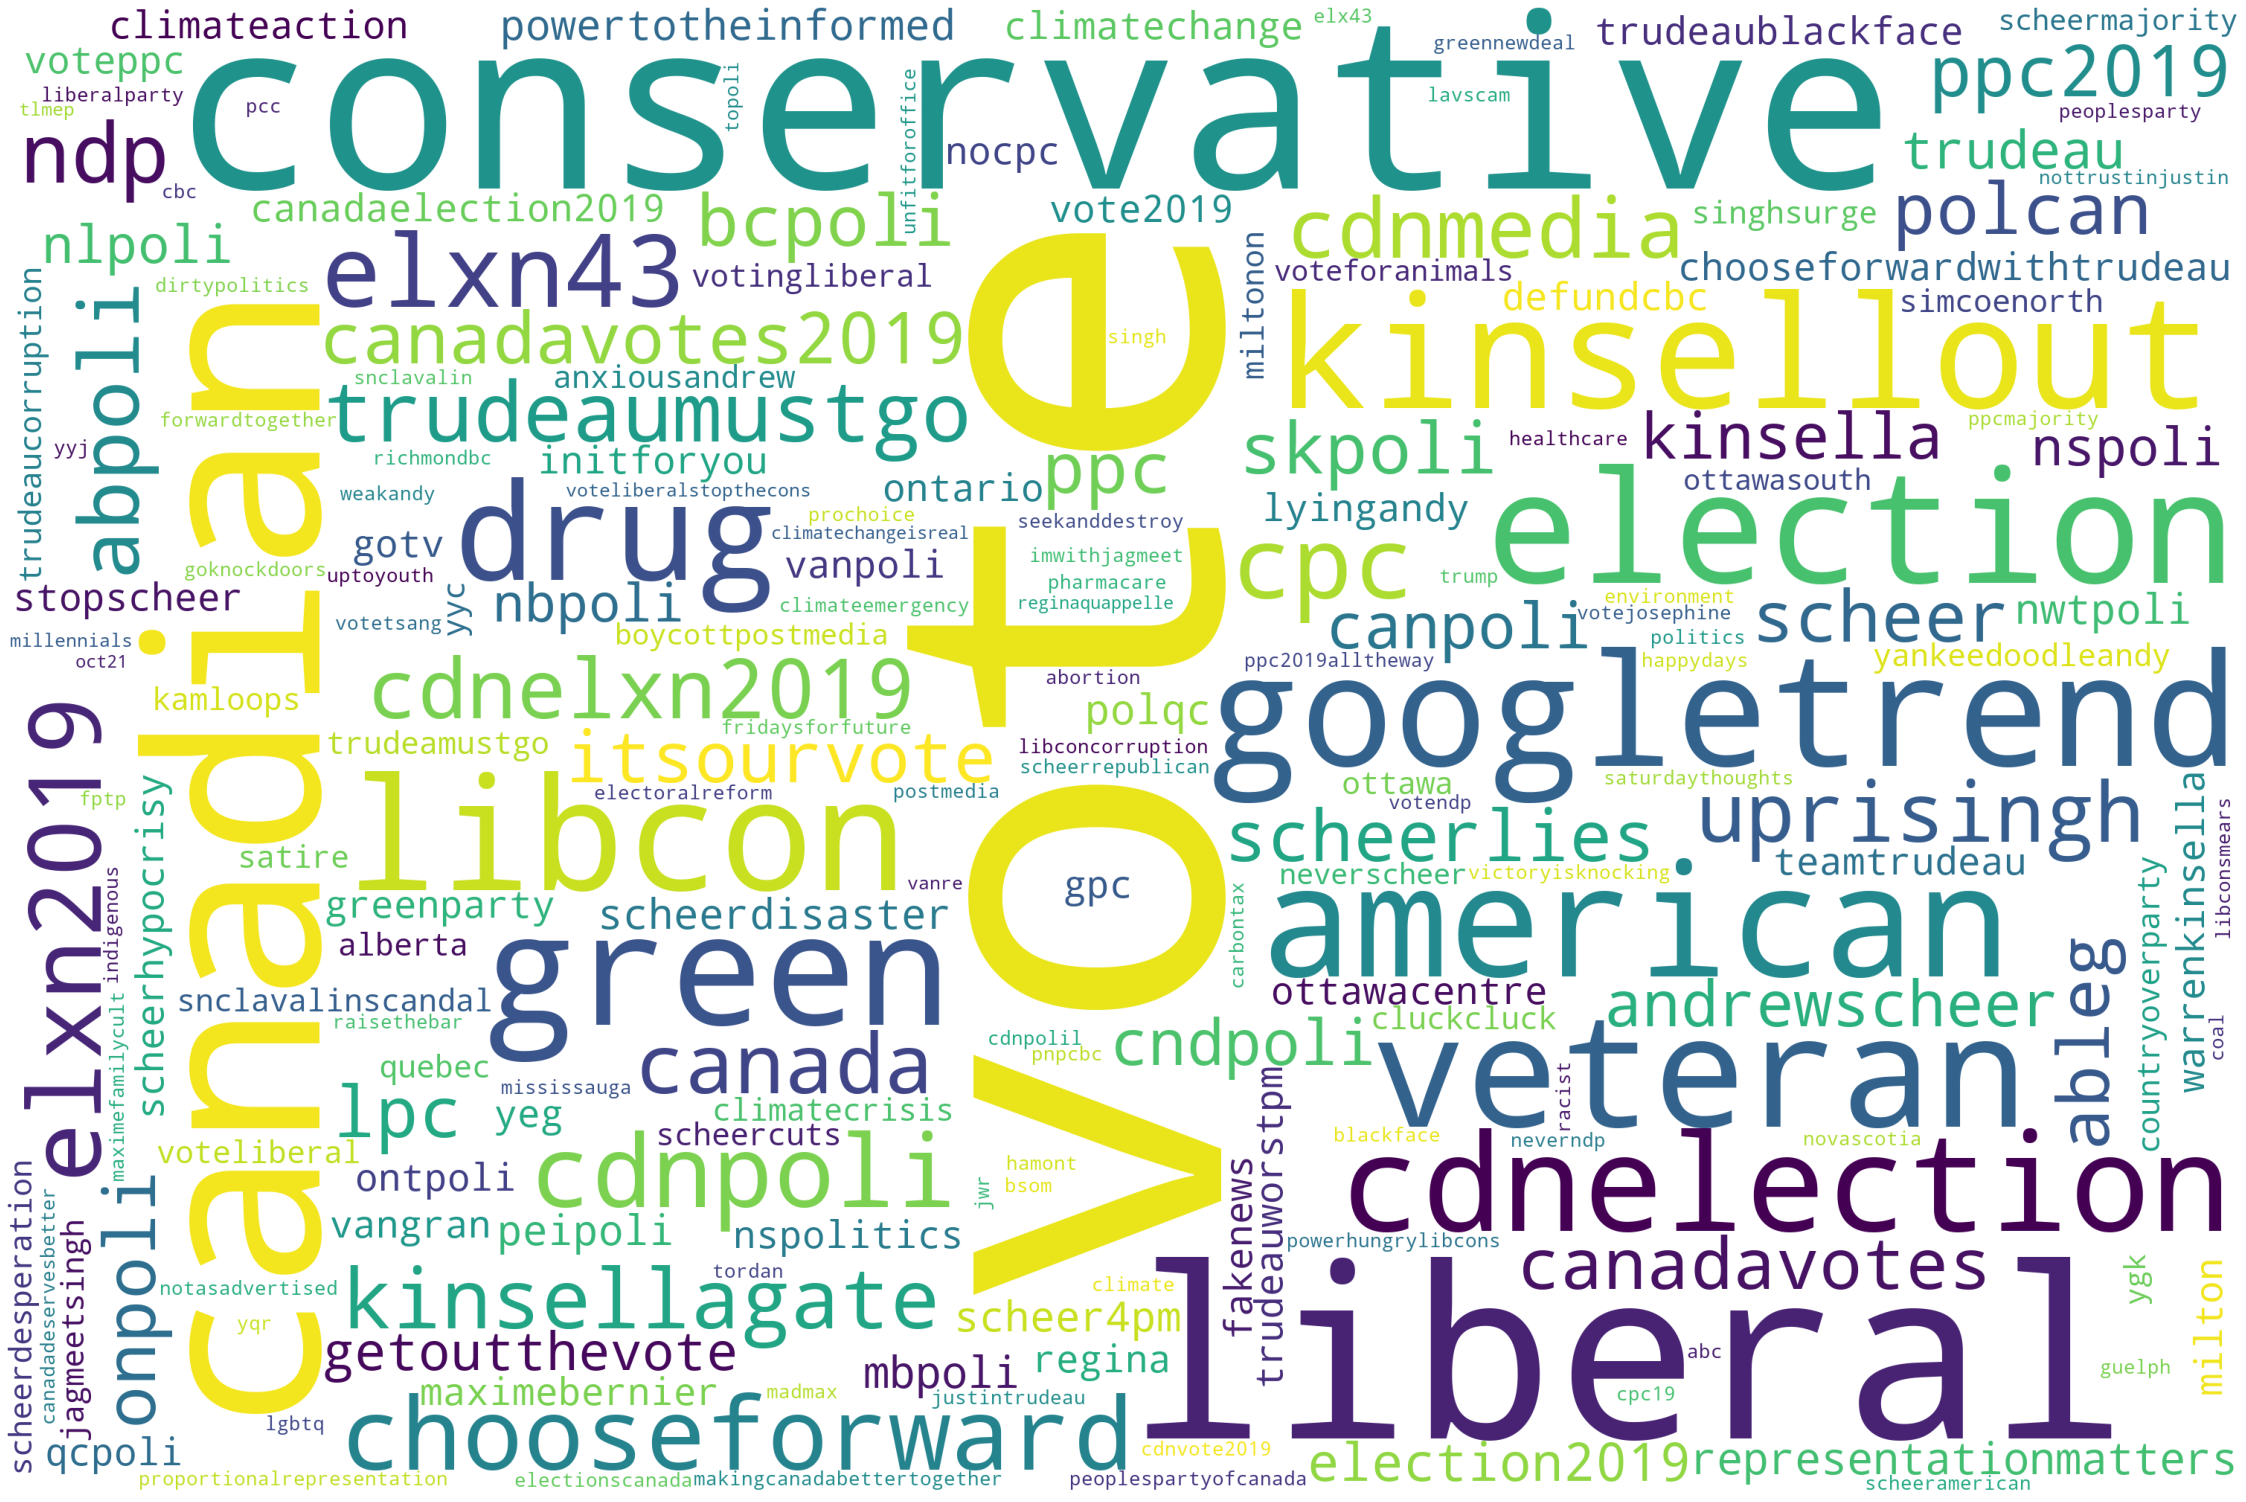

In [18]:
#election hashtag wordcloud graph
election_hashtag_string = ' '
election_hashtag_string = election_hashtag_string.join(df_election_hashtags['hashtag'].values.tolist())
wordcloud = WordCloud(width = 3000, height = 2000, random_state=0, background_color='white', collocations=False, stopwords = STOPWORDS).generate(election_hashtag_string)
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud) 
plt.axis("off")
plt.show()

In [19]:
#using the new mention column in the election dataset
#count the mentions and rank them by frequency

election_mentions = []
election_mentions_freq = []
for i in election_text_df['mention']:
    for j in i:
        j = j.replace('@','')
        j = j.lower()
        if j in election_mentions:
            index = election_mentions.index(j)
            election_mentions_freq[index]+=1
        else:
            election_mentions.append(j)
            election_mentions_freq.append(1)

df_election_mentions = pd.DataFrame(zip(election_mentions,election_mentions_freq), 
                                    columns = ['mention','frequency'])
df_election_mentions = df_election_mentions.sort_values(by='frequency', 
                                                        ascending=False, ignore_index=True)
df_election_mentions

mention  frequency
0       andrewscheer        170
1      justintrudeau        128
2             cpc_hq         91
3    thejagmeetsingh         62
4      liberal_party         47
..               ...        ...
826   peterdowningab          1
827   independenceab          1
828         bobrae48          1
829      bowker_john          1
830          khayhoe          1

[831 rows x 2 columns]

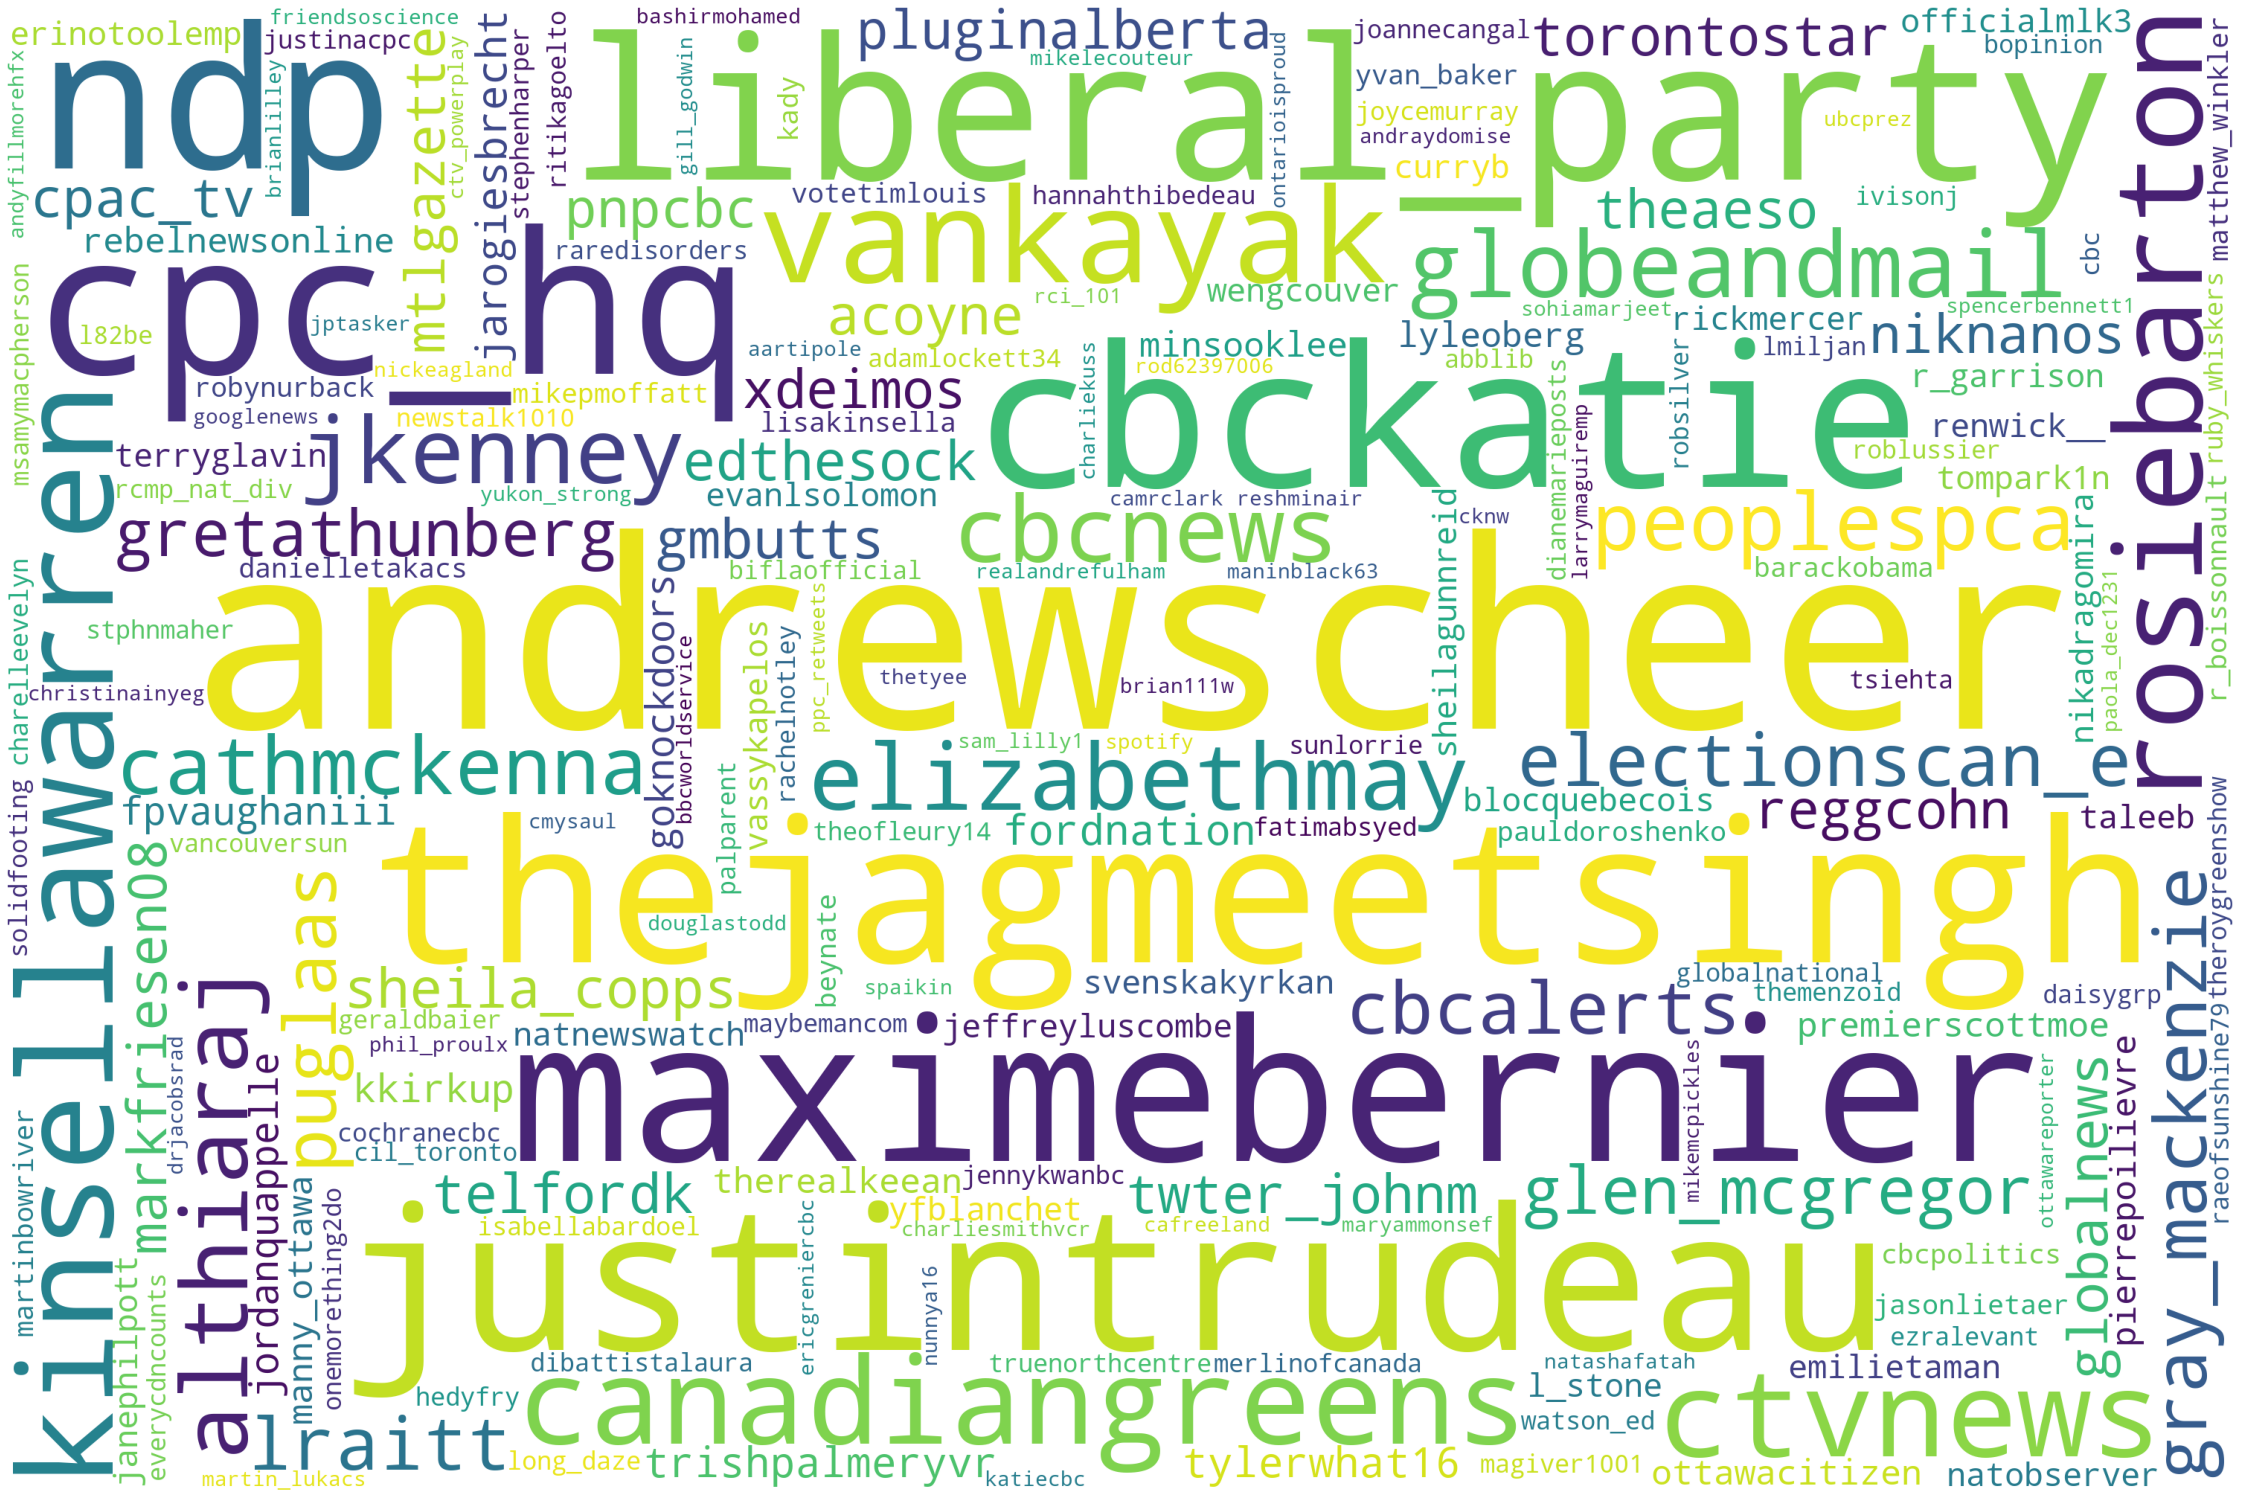

In [20]:
#election mention wordcloud graph
election_mention_string = ' '
election_mention_string = election_mention_string.join(df_election_mentions['mention'].values.tolist())
wordcloud = WordCloud(width = 3000, height = 2000, random_state=0, background_color='white', collocations=False, stopwords = STOPWORDS).generate(election_mention_string)
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud) 
plt.axis("off")
plt.show()

In [21]:
#analysing the mentions, the hashtags and using some common sense
#we can identify some keywords for each party

lib = ['liberal','liberals','lib','trudeaumustgo','lpc','trudeau','chooseforwardwithtrudeau',
       'trudeaublackface','teamtrudeau','justintrudeau','vankayak','cathmckenna','sheila_copps',
       'gmbutts','justin','trudeauworstpm','trudeaucorruption','votingliberal','snclavalinscandal',
      'voteliberal','trudeamustgo','telfordk','beynate','ivotedliberal']
cpc = ['conservative','conservatives','cpc','kinsellagate','scheerlies','scheer','andrewscheer',
       'kinsella','scheerdisaster','scheer4pm','lyingandy','kinsellawarren','jkenney',
      'lraitt','andrew','stopscheer','scheerhypocrisy','warrenkinsella','warren',
      'nocpc','yankeedoodleandy','kinsellouts','scheerdesperation','anxiousandrew','scheercuts',
      'scheermajority','neverscheer','weakandy','fordnation','pierrepoilievre','ford','andy']
ndp = ['democratic','ndp','uprisingh','initforyou','thejagmeetsingh','singh','jagmeet',
      'jagmeetsingh','singhsurge']
ppc = ['ppc','ppc2019','maximebernier','peoplespca','voteppc','markfriesen08']
green = ['canadiangreens','elizabethmay','elizabeth','may','gpc','greenparty','green']

In [22]:
#function to identify which party a tweet belongs to
#for each tweet, all parties start from score zero, if the tweet mentions the keywords of a party
#1 is added to that the total score of that particular party
#when the end of the tweet is reached, the party with the highest score is selected
#if no keywords were mentioned in the entire tweet (ie all scores are 0)
#then "inconclusive" is selected

def choose_party(sample,lib,cpc,ndp,ppc,green):
    counter_dic = {
        "liberal":0,
        "conservative":0,
        "new democratic":0,
        "peoples":0,
        "green":0
    }
    
    words = nltk.word_tokenize(sample)
    for word in words:
        if word in lib:
            counter_dic["liberal"] += 1
        elif word in cpc:
            counter_dic["conservative"] += 1
        elif word in ndp:
            counter_dic["new democratic"] += 1
        elif word in ppc:
            counter_dic["peoples"] += 1
        elif word in green:
            counter_dic["green"] += 1
    
    if all(value == 0 for value in counter_dic.values()):
        return "inconclusive"
    else:
        return max(counter_dic.items(), key=operator.itemgetter(1))[0]

In [23]:
#choose party for each tweet
election_text_df['party'] = election_text_df['text'].apply(lambda x: choose_party(x,lib,cpc,ndp,ppc,green))

In [24]:
#take a look at the dataset to see the new party column
election_text_df

text  ...           party
0     rosiebarton instead suggestion agree canadian ...  ...    conservative
1     allwomanspacewalk real space station etobicoke...  ...    inconclusive
2     brantford going cost billion next years ask ju...  ...         liberal
3     canada canadaelection2019 canadavotes el3 deci...  ...    inconclusive
4     canada tayers sick tired hard earned donated c...  ...         liberal
...                                                 ...  ...             ...
2128  know good enough job smearing campaign right a...  ...    conservative
2129  missed comment deflecting issue answer best re...  ...    conservative
2130  daily reminder thejagmeetsingh endorses strate...  ...  new democratic
2131  yup going reopen abortion debate el3 scheerlie...  ...    conservative
2132                                       zing ndp el3  ...  new democratic

[2133 rows x 4 columns]

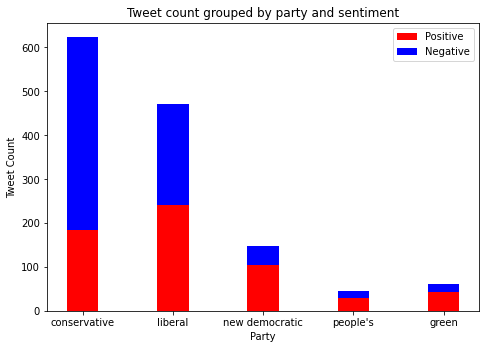

In [25]:
#For the tweets that have known parties (ie, not 'inconclusive')
#graph the number of tweets grouped by party and sentiment
party_sentiment_df = election_text_df['party'].to_frame()
party_sentiment_df['sentiment'] = election_sentiment_label

positive_tweet_count = (party_sentiment_df.loc[party_sentiment_df['party']=='conservative']['sentiment'].sum(),
party_sentiment_df.loc[party_sentiment_df['party']=='liberal']['sentiment'].sum(),
party_sentiment_df.loc[party_sentiment_df['party']=='new democratic']['sentiment'].sum(),
party_sentiment_df.loc[party_sentiment_df['party']=='peoples']['sentiment'].sum(),
party_sentiment_df.loc[party_sentiment_df['party']=='green']['sentiment'].sum())

negative_tweet_count = (party_sentiment_df.loc[party_sentiment_df['party']=='conservative']['party'].count()-party_sentiment_df.loc[party_sentiment_df['party']=='conservative']['sentiment'].sum(),
                        party_sentiment_df.loc[party_sentiment_df['party']=='liberal']['party'].count()-party_sentiment_df.loc[party_sentiment_df['party']=='liberal']['sentiment'].sum(),
                        party_sentiment_df.loc[party_sentiment_df['party']=='new democratic']['party'].count()-party_sentiment_df.loc[party_sentiment_df['party']=='new democratic']['sentiment'].sum(),
                        party_sentiment_df.loc[party_sentiment_df['party']=='peoples']['party'].count()-party_sentiment_df.loc[party_sentiment_df['party']=='peoples']['sentiment'].sum(),
                        party_sentiment_df.loc[party_sentiment_df['party']=='green']['party'].count()-party_sentiment_df.loc[party_sentiment_df['party']=='green']['sentiment'].sum())

N = 5
ind = np.arange(N) # the x locations for the groups
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, positive_tweet_count, width, color='r')
ax.bar(ind, negative_tweet_count, width,bottom=positive_tweet_count, color='b')
ax.set_ylabel('Tweet Count')
ax.set_xlabel('Party')
ax.set_title('Tweet count grouped by party and sentiment')
ax.set_xticks(ind)
ax.set_xticklabels(('conservative', 'liberal', 'new democratic', "people's", 'green'))
# ax.set_yticks(np.arange(0, 81, 10))
ax.legend(labels=['Positive', 'Negative'])
plt.show()




**Exploratory Analysis** Tweet Sentiment and Party

From the graph above we can see that, with more than 600 tweets, the party that is most talked about is the conservative party. Followed closely by the liberal party with almost 500 tweets. The new democratic party is less heated, only has less than 200 tweets, and even less for the people's party and the green party.

However, as shown with the color blue, the tweet sentiment towards the conservative party is largely negative. More than two thirds of the tweets about the conservative party are negative. The liberal party has a close to equal mix of positive and negative tweets. The parties that were less discussed (new democratic, people's and green), all have more supportive tweets than negative ones.

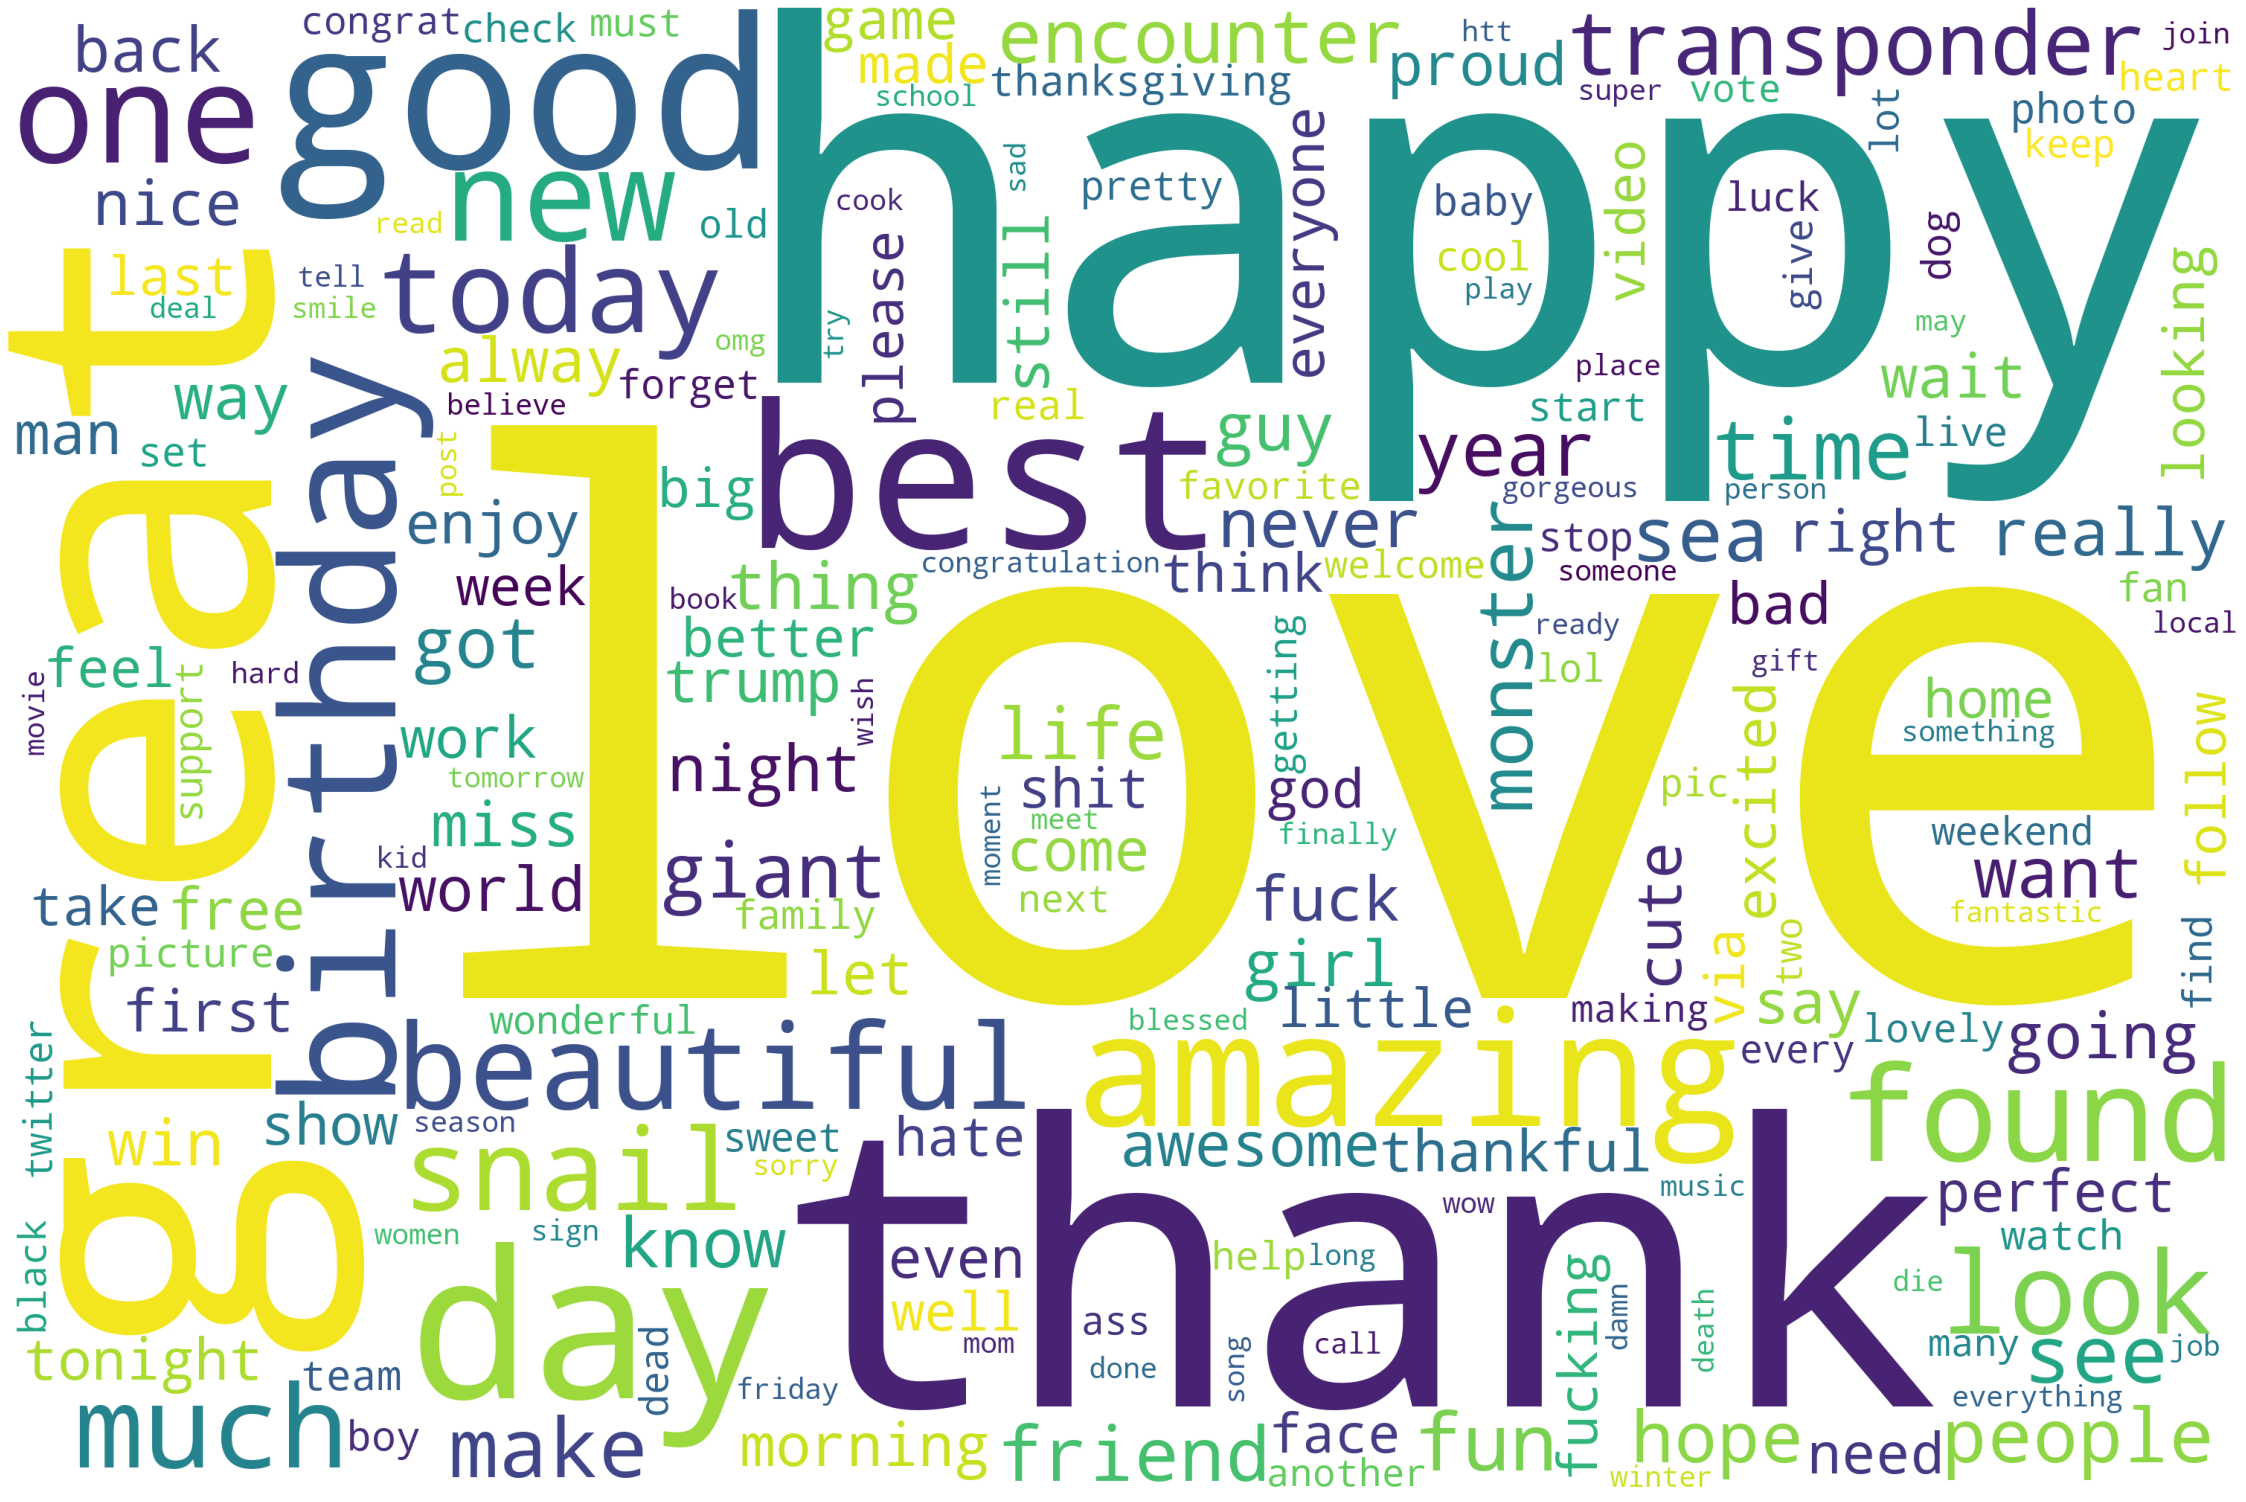

In [26]:
#sentiment dataset wordcloud graph
sentiment_text_string = ' '
sentiment_text_string = sentiment_text_string.join(clean_sentiment.values.tolist())
wordcloud = WordCloud(width = 3000, height = 2000, random_state=0, background_color='white', collocations=False, stopwords = STOPWORDS).generate(sentiment_text_string)
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud) 
plt.axis("off")
plt.show()

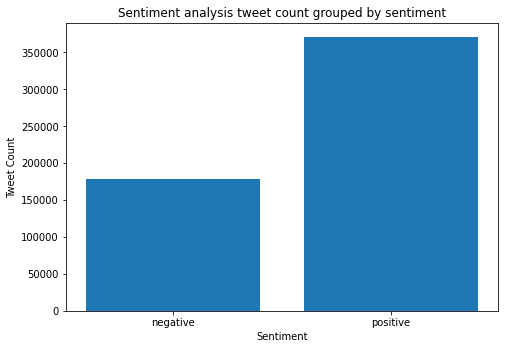

In [27]:
#from the wordcloud above, we can see mostly positive words
#graph the bar plot to see the positive and negative tweet count for sentiment analysis data
#as suspected the positive tweet count outweigh the negative tweet count by around 50%
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
senti = ['negative', 'positive']
count = [sentiment_label[sentiment_label==0].count(),sentiment_label[sentiment_label==1].count()]
ax.bar(senti,count)
ax.set_ylabel('Tweet Count')
ax.set_xlabel('Sentiment')
ax.set_title('Sentiment analysis tweet count grouped by sentiment')
plt.show()

We can see from the WordCloud graph that most words with high frequency are very positive words, such as “love” “happy”, “thank” and “great”. This observation is confirmed with the histogram, which shows the generic tweets grouped by their sentiment labels. The number of positive tweets doubles the amount of negative tweets, which could explain the word frequency.


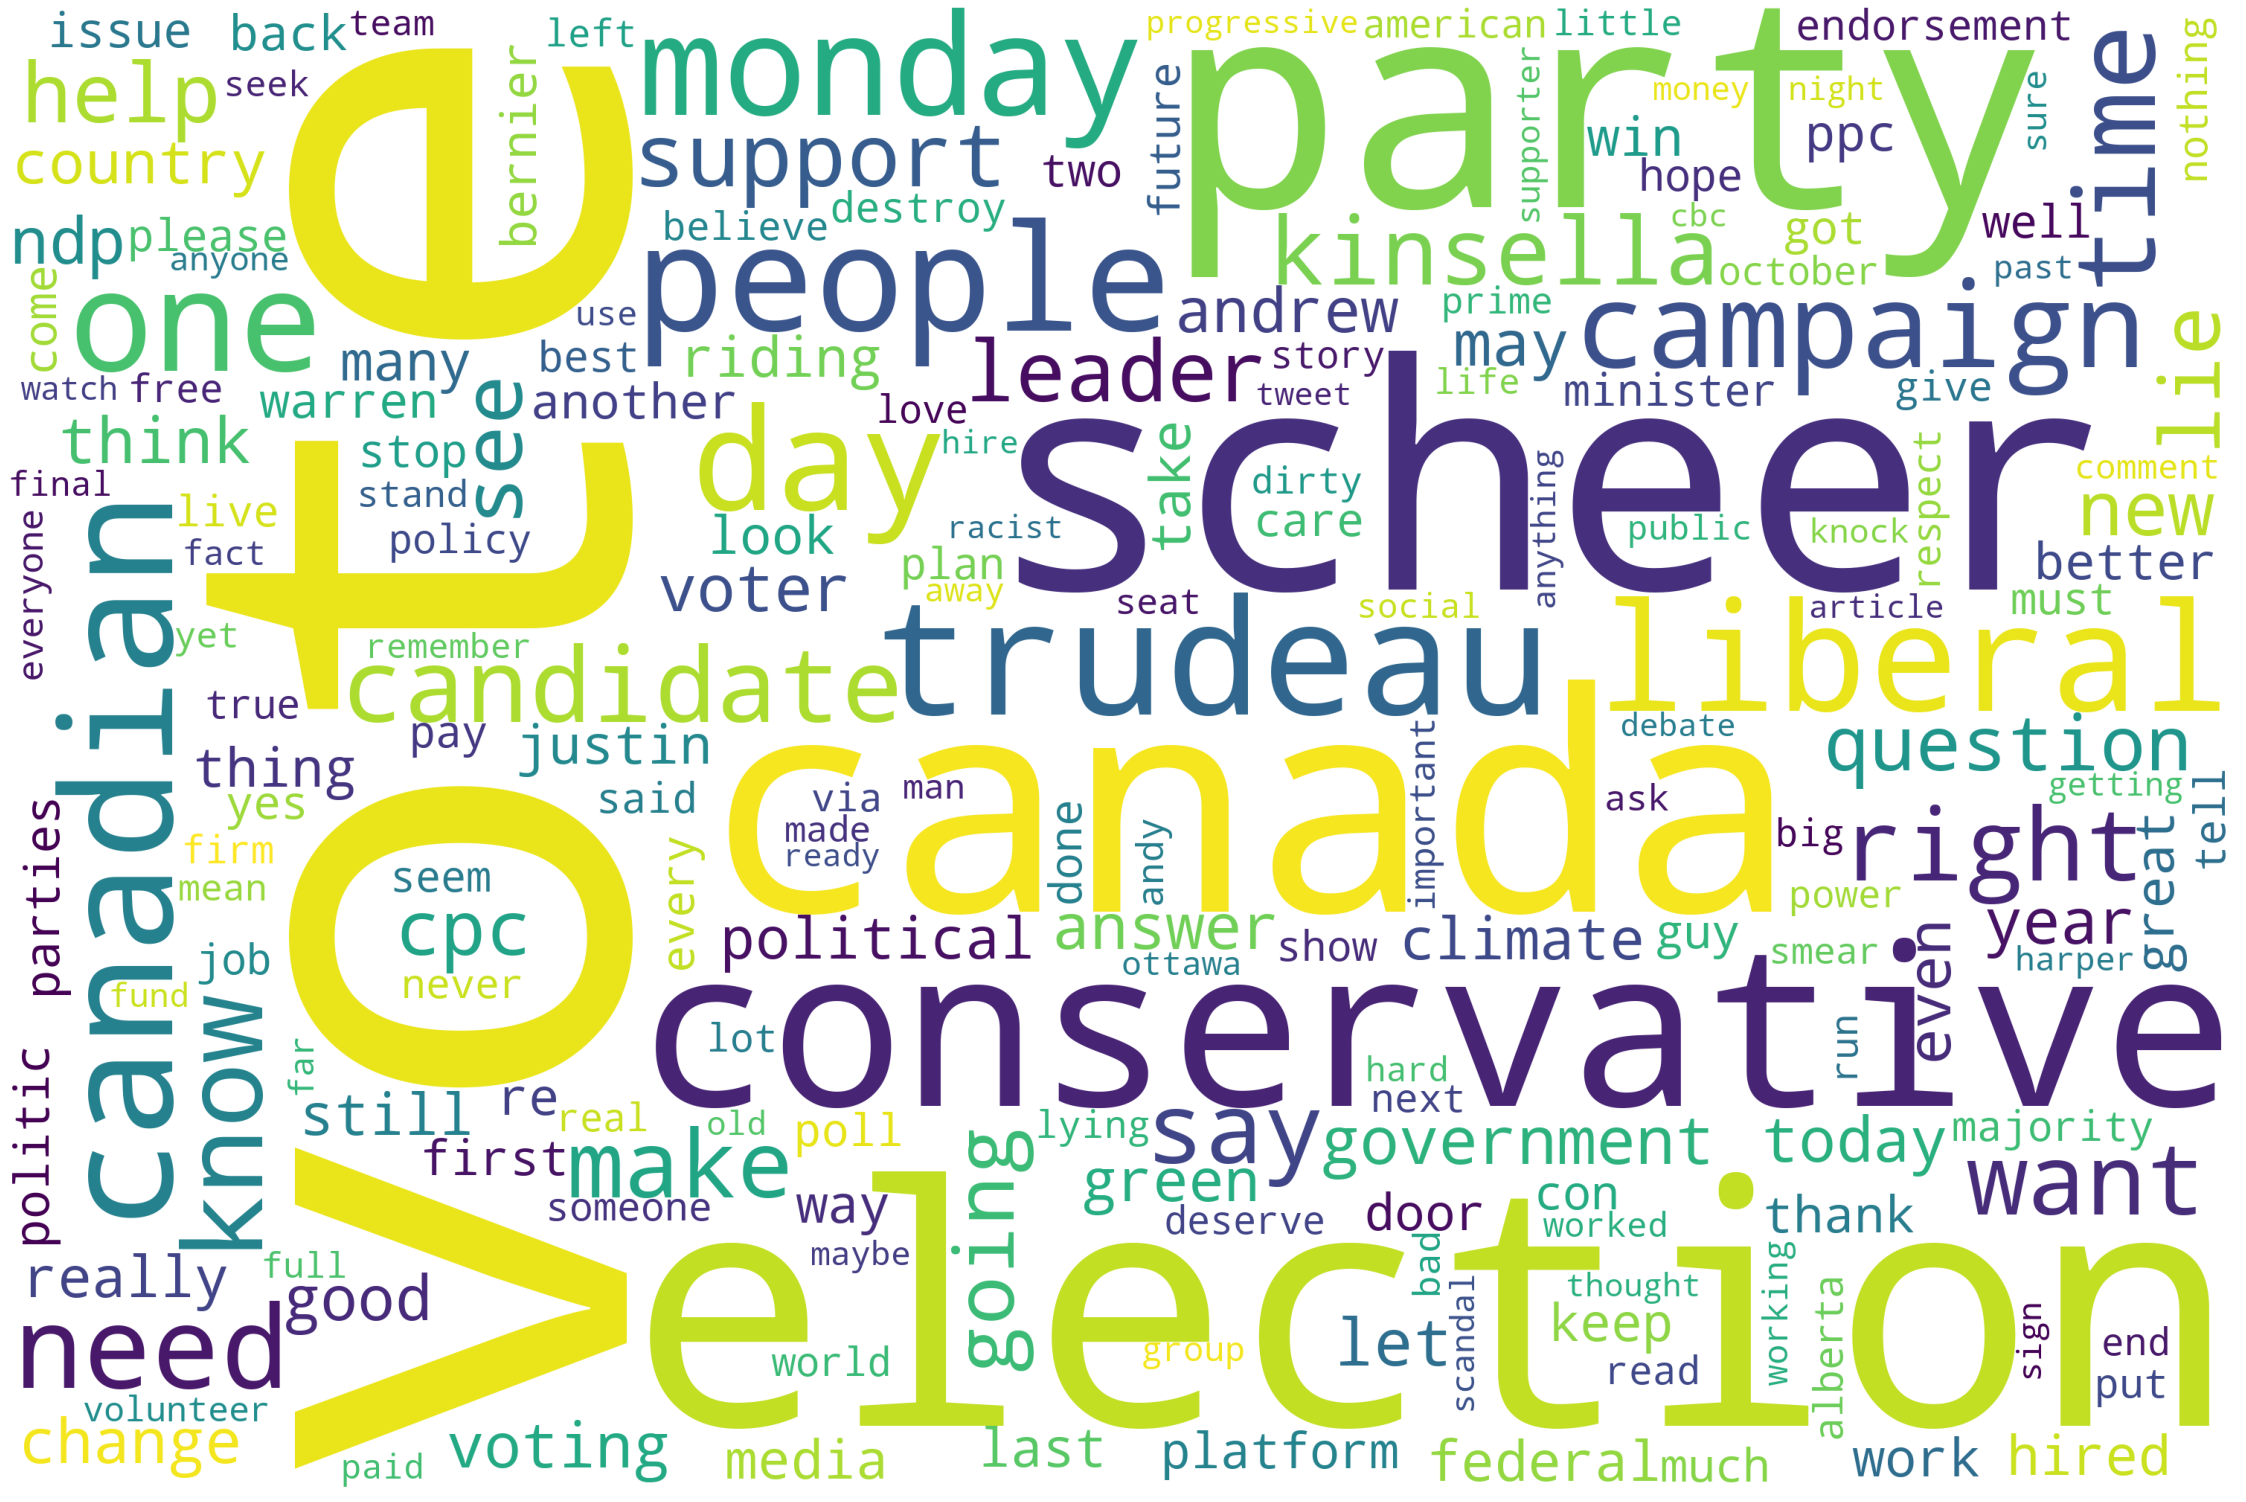

In [28]:
#election dataset wordcloud graph
election_text_string = ' '
election_text_string = election_text_string.join(clean_election_text.values.tolist())
wordcloud = WordCloud(width = 3000, height = 2000, random_state=0, background_color='white', collocations=False, stopwords = STOPWORDS).generate(election_text_string)
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud) 
plt.axis("off")
plt.show()

The most used words are “vote”, “election” “canada” etc, which is to be expected because people are likely using social media to encourage Canadian citizens to vote. The keywords related to the conservative party and the liberal party are also mentioned a lot, such as “conservative” and its candidate “scheer”, “liberal” and its candidate “trudeau”. Comparatively, other parties, such as “ndp” are hard to be found, suggesting they are mentioned a lot less than the popular parties.

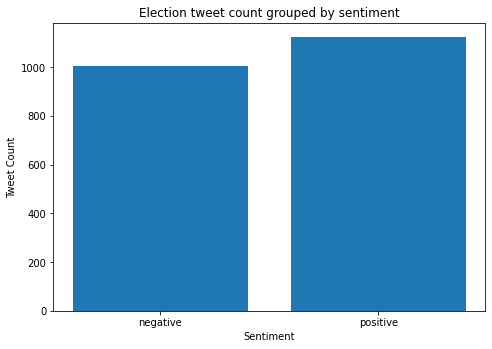

In [29]:
#graph the bar plot to see the positive and negative tweet count for the election dataset
#there are slightly more positive tweets than negative tweets in the election dataset
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
senti = ['negative', 'positive']
count = [election_sentiment_label[election_sentiment_label==0].count(),election_sentiment_label[election_sentiment_label==1].count()]
ax.bar(senti,count)
ax.set_ylabel('Tweet Count')
ax.set_xlabel('Sentiment')
ax.set_title('Election tweet count grouped by sentiment')
plt.show()

There are slightly more positive tweets than negative tweets in the election dataset, overall pretty balanced

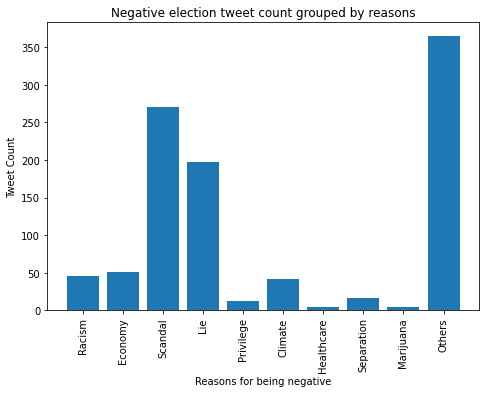

In [30]:
#graph the bar plot to see the negative tweet count grouped by reasons for the election dataset
#the two most appeared reasons are "scandal" and "tell lies" (not counting "others")
#some of the labels are abbraviated for better readibility
#'Women Reproductive right and Racism' to "Racism"
#"Tell lies" to "lie", "Climate Problem" to "Climate", "Healthcare and Marijuana" to "Marijuana"
negative_reason_graph = election_df['negative_reason'].dropna()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
reasons = ['Racism', 'Economy','Scandal', 'Lie', 'Privilege', 'Climate',
       'Healthcare', 'Separation', 'Marijuana', 'Others']
counts = [negative_reason_graph[negative_reason_graph=='Women Reproductive right and Racism'].count(),
            negative_reason_graph[negative_reason_graph=='Economy'].count(),
            negative_reason_graph[negative_reason_graph=='Scandal'].count(),
            negative_reason_graph[negative_reason_graph=='Tell lies'].count(),
            negative_reason_graph[negative_reason_graph=='Privilege'].count(),
            negative_reason_graph[negative_reason_graph=='Climate Problem'].count(),
            negative_reason_graph[negative_reason_graph=='Healthcare'].count(),
            negative_reason_graph[negative_reason_graph=='Separation'].count(),
            negative_reason_graph[negative_reason_graph=='Healthcare and Marijuana'].count(),
            negative_reason_graph[negative_reason_graph=='Others'].count()]
ax.bar(reasons,counts)
ax.set_ylabel('Tweet Count')
ax.set_xlabel('Reasons for being negative')
ax.set_title('Negative election tweet count grouped by reasons')
plt.xticks(rotation=90)
plt.show()



This graph reveals the reason why the tweets were negative. Apart from the “other” category, which does not give us much information, the reason that is most used is “scandal” and “tell lies”, followed by “economy”, “climate change” and “Women reproductive right and racism” This distribution can help later when we are trying to predict the negative reasons for the negative elections tweets.

# Sentiment Prediction Models

In [31]:
!pip install xgboost

In [32]:
#import libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [33]:
#split the generic tweets randomly into training data (70%) and test data (30%)
X_train_sentiment, X_test_sentiment, y_train_sentiment, y_test_sentiment = train_test_split(
    clean_sentiment, sentiment_label, test_size=0.3, random_state=42)

## Bag of Words Encoding

Without limiting the maximum number of features, both the BOW and TD-IDF encoding methods generated 104,700 features, which is a very large number. To avoid “the curse of dimensionality” and also improve efficiency, the maximum number of features is set to be 50,000. This is because the average adult english native speaker have a vocabulary range of 20,000 to 35,000, giving some extra room for variations of the same word, the 50,000 features should represent the words that carry the most meaning.

In [34]:
#create bag of words encoding
#only fit the vectorizer on the training data from the generic tweets
#then transform the test data from the generic tweets
#check the length of the vocabulary generated
#Without limiting the maximum number of features, the encoding generates 104,700 features
#the maximum number of features is set to be 50,000
#because the average adult english native speaker have a vocabulary range of 20,000 to 35,000 [1]
#plus some buffer room for variations of the same word

bow_vectorizer = CountVectorizer(max_features=50000)
bow_vectorizer.fit(X_train_sentiment)

X_train_sentiment_bow = bow_vectorizer.transform(X_train_sentiment)
X_test_sentiment_bow = bow_vectorizer.transform(X_test_sentiment)

print(f"length of vocabulary is: {len(bow_vectorizer.vocabulary_)}")

length of vocabulary is: 50000


In [35]:
#test models with bag of words encoding
#f1 score is used for assessment creteria with accuracy score as supplementry
print("Bag of Words Encoding")

#logistic regression
bow_logit = LogisticRegression(max_iter=500).fit(X_train_sentiment_bow, y_train_sentiment)
print(f"Logistic regression accuracy: {accuracy_score(y_test_sentiment,bow_logit.predict(X_test_sentiment_bow))}")
print(f"Logistic regression f1 score: {f1_score(y_test_sentiment,bow_logit.predict(X_test_sentiment_bow))}\n")

#knn
bow_knn = KNeighborsClassifier(n_neighbors=2).fit(X_train_sentiment_bow, y_train_sentiment)
print(f"K-nearest neighbors accuracy: {accuracy_score(y_test_sentiment,bow_knn.predict(X_test_sentiment_bow))}")
print(f"K-nearest neighbors f1 score: {f1_score(y_test_sentiment,bow_knn.predict(X_test_sentiment_bow))}\n")

#Both multinomial and complement Naive Bayes are commonly used in text classification, therefore they are both experimented in the assignment.
#multinomial naive bayes
bow_multinomialNB = MultinomialNB().fit(X_train_sentiment_bow, y_train_sentiment)
print(f"Multinomial naive bayes accuracy: {accuracy_score(y_test_sentiment,bow_multinomialNB.predict(X_test_sentiment_bow))}")
print(f"Multinomial naive bayes f1 score: {f1_score(y_test_sentiment,bow_multinomialNB.predict(X_test_sentiment_bow))}\n")

#complement naive bayes
bow_complementNB = ComplementNB().fit(X_train_sentiment_bow, y_train_sentiment)
print(f"Complement naive bayes accuracy: {accuracy_score(y_test_sentiment,bow_complementNB.predict(X_test_sentiment_bow))}")
print(f"Complement naive bayes f1 score: {f1_score(y_test_sentiment,bow_complementNB.predict(X_test_sentiment_bow))}\n")

#linear SVC
#Linear SVC is selected from the SVM module because it is faster with larger dataset.
bow_linearSVC = LinearSVC(random_state=0).fit(X_train_sentiment_bow,y_train_sentiment)
print(f"Linear SVC accuracy: {accuracy_score(y_test_sentiment,bow_linearSVC.predict(X_test_sentiment_bow))}")
print(f"Linear SVC f1 score: {f1_score(y_test_sentiment,bow_linearSVC.predict(X_test_sentiment_bow))}\n")

#decision tree
bow_decisiontree = DecisionTreeClassifier(random_state=0).fit(X_train_sentiment_bow,
                                                              y_train_sentiment)
print(f"Decision tree accuracy: {accuracy_score(y_test_sentiment,bow_decisiontree.predict(X_test_sentiment_bow))}")
print(f"Decision tree f1 score: {f1_score(y_test_sentiment,bow_decisiontree.predict(X_test_sentiment_bow))}\n")

#random forest
bow_randomforest = RandomForestClassifier(max_depth=100,random_state=0).fit(X_train_sentiment_bow,y_train_sentiment)
print(f"Random Forest accuracy: {accuracy_score(y_test_sentiment,bow_randomforest.predict(X_test_sentiment_bow))}")
print(f"Random Forest f1 score: {f1_score(y_test_sentiment,bow_randomforest.predict(X_test_sentiment_bow))}\n")


#XGBoost
bow_XGB = XGBClassifier(n_jobs=1).fit(X_train_sentiment_bow,y_train_sentiment, eval_metric='error')
print(f"XGBoost accuracy: {accuracy_score(y_test_sentiment,bow_XGB.predict(X_test_sentiment_bow))}")
print(f"XGBoost f1 score: {f1_score(y_test_sentiment,bow_XGB.predict(X_test_sentiment_bow))}")

Bag of Words Encoding
Logistic regression accuracy: 0.9716445208880922
Logistic regression f1 score: 0.9789487882739085

K-nearest neighbors accuracy: 0.9092467205271382
K-nearest neighbors f1 score: 0.930018820430675

Multinomial naive bayes accuracy: 0.9488729272399132
Multinomial naive bayes f1 score: 0.9624118401367813

Complement naive bayes accuracy: 0.9508109352099711
Complement naive bayes f1 score: 0.963190573306141

Linear SVC accuracy: 0.969827638416163
Linear SVC f1 score: 0.9775981150401094

Decision tree accuracy: 0.936209256410567
Decision tree f1 score: 0.9534080302916366

Random Forest accuracy: 0.8477815865017745
Random Forest f1 score: 0.898256096376178

XGBoost accuracy: 0.8537470172846086
XGBoost f1 score: 0.8801663350221565


In [36]:
#Using the random forest model to look at the top 10 feature importance
print("The 10 most important features in bag of words encoding")
print("identified by the Random Forest Algorithm are:\n")
top10_features_bow = bow_randomforest.feature_importances_.argsort()[-10:][::-1]
for i in top10_features_bow:
    print(bow_vectorizer.get_feature_names()[i], bow_randomforest.feature_importances_[i])

The 10 most important features in bag of words encoding
identified by the Random Forest Algorithm are:

love 0.049378686997150256
happy 0.04375926001106075
best 0.0282445132610831
great 0.027806316359472817
amazing 0.026790109343563046
good 0.024661186203488016
birthday 0.02015637176039827
hate 0.016345682256500075
beautiful 0.01621141130693693
fuck 0.01552801023023793


## TF-IDF Encoding

In [37]:
#create TF-IDF encoding
#only fit the vectorizer on the training data from the generic tweets
#then transform the test data from the generic tweets
#check the length of the vocabulary generated
tfidf_vectorizer = TfidfVectorizer(max_features=50000)
tfidf_vectorizer.fit(X_train_sentiment)

X_train_sentiment_tfidf = tfidf_vectorizer.transform(X_train_sentiment)
X_test_sentiment_tfidf = tfidf_vectorizer.transform(X_test_sentiment)

print(f"length of vocabulary is: {len(tfidf_vectorizer.vocabulary_)}")

length of vocabulary is: 50000


In [38]:
#test models with bag of words encoding
print("TF-IDF Encoding")
#logistic regression
tfidf_logit = LogisticRegression(max_iter=500).fit(X_train_sentiment_tfidf, y_train_sentiment)
print(f"Logistic regression accuracy: {accuracy_score(y_test_sentiment,tfidf_logit.predict(X_test_sentiment_tfidf))}")
print(f"Logistic regression f1 score: {f1_score(y_test_sentiment,tfidf_logit.predict(X_test_sentiment_tfidf))}\n")

#knn
tfidf_knn = KNeighborsClassifier(n_neighbors=2).fit(X_train_sentiment_tfidf, y_train_sentiment)
print(f"K-nearest neighbors accuracy: {accuracy_score(y_test_sentiment,tfidf_knn.predict(X_test_sentiment_tfidf))}")
print(f"K-nearest neighbors f1 score: {f1_score(y_test_sentiment,tfidf_knn.predict(X_test_sentiment_tfidf))}\n")

#multinomial naive bayes
tfidf_multinomialNB = MultinomialNB().fit(X_train_sentiment_tfidf, y_train_sentiment)
print(f"Multinomial naive bayes accuracy: {accuracy_score(y_test_sentiment,tfidf_multinomialNB.predict(X_test_sentiment_tfidf))}")
print(f"Multinomial naive bayes f1 score: {f1_score(y_test_sentiment,tfidf_multinomialNB.predict(X_test_sentiment_tfidf))}\n")

#complement naive bayes
tfidf_complementNB = ComplementNB().fit(X_train_sentiment_tfidf, y_train_sentiment)
print(f"Complement naive bayes accuracy: {accuracy_score(y_test_sentiment,tfidf_complementNB.predict(X_test_sentiment_tfidf))}")
print(f"Complement naive bayes f1 score: {f1_score(y_test_sentiment,tfidf_complementNB.predict(X_test_sentiment_tfidf))}\n")

#linear SVC
tfidf_linearSVC = LinearSVC(random_state=0).fit(X_train_sentiment_tfidf,y_train_sentiment)
print(f"Linear SVC accuracy: {accuracy_score(y_test_sentiment,tfidf_linearSVC.predict(X_test_sentiment_tfidf))}")
print(f"Linear SVC f1 score: {f1_score(y_test_sentiment,tfidf_linearSVC.predict(X_test_sentiment_tfidf))}\n")

#decision tree
tfidf_decisiontree = DecisionTreeClassifier(random_state=0).fit(X_train_sentiment_tfidf,y_train_sentiment)
print(f"Decision tree accuracy: {accuracy_score(y_test_sentiment,tfidf_decisiontree.predict(X_test_sentiment_tfidf))}")
print(f"Decision tree f1 score: {f1_score(y_test_sentiment,tfidf_decisiontree.predict(X_test_sentiment_tfidf))}\n")

#random forest
tfidf_randomforest = RandomForestClassifier(max_depth=100,random_state=0).fit(X_train_sentiment_tfidf,y_train_sentiment)
print(f"Random Forest accuracy: {accuracy_score(y_test_sentiment,tfidf_randomforest.predict(X_test_sentiment_tfidf))}")
print(f"Random Forest f1 score: {f1_score(y_test_sentiment,tfidf_randomforest.predict(X_test_sentiment_tfidf))}\n")

#XGBoost
tfidf_XGB = XGBClassifier(n_jobs=1).fit(X_train_sentiment_tfidf,y_train_sentiment, eval_metric='error')
print(f"XGBoost accuracy: {accuracy_score(y_test_sentiment,tfidf_XGB.predict(X_test_sentiment_tfidf))}")
print(f"XGBoost f1 score: {f1_score(y_test_sentiment,tfidf_XGB.predict(X_test_sentiment_tfidf))}")

TF-IDF Encoding
Logistic regression accuracy: 0.9702758027592389
Logistic regression f1 score: 0.9779524729347289

K-nearest neighbors accuracy: 0.7164330963311086
K-nearest neighbors f1 score: 0.7424532453245325

Multinomial naive bayes accuracy: 0.9295655228382127
Multinomial naive bayes f1 score: 0.9494237877799521

Complement naive bayes accuracy: 0.9386499351978586
Complement naive bayes f1 score: 0.9538887320994511

Linear SVC accuracy: 0.9713780447922092
Linear SVC f1 score: 0.9787647042964854

Decision tree accuracy: 0.9459961966593587
Decision tree f1 score: 0.9600172181095055

Random Forest accuracy: 0.8462251238508218
Random Forest f1 score: 0.8973125998422745

XGBoost accuracy: 0.8537772986591408
XGBoost f1 score: 0.8802024412027388


In [39]:
#Using the random forest model to look at the top 10 feature importance
print("The 10 most important features in TF-IDF encoding")
print("identified by the Random Forest Algorithm are:\n")
top10_features_tfidf = tfidf_randomforest.feature_importances_.argsort()[-10:][::-1]
for i in top10_features_tfidf:
    print(tfidf_vectorizer.get_feature_names()[i], tfidf_randomforest.feature_importances_[i])

The 10 most important features in TF-IDF encoding
identified by the Random Forest Algorithm are:

love 0.04298431438100437
happy 0.04090567509619716
great 0.029765605159056067
best 0.027749667843147564
good 0.026388618192746006
amazing 0.024533566043340973
birthday 0.019446497658788264
fuck 0.015952533084032702
hate 0.015677184647836996
thanks 0.013612727088356223


High importance features are very polarized in the sentiment they are representing. 

“Love”, “happy”, “great”, “best”, “good” and “amazing” are strongly positive

“fu*k” and “bad” are strongly negative

The sentiment of the word can largely represent the sentiment of the tweet when the subject is not complex.

The important features coincides with words that appeared in high frequency


## Apply Best Model

In [40]:
#The best model from the sentiment dataset is
#bag of words encoding with logistic regression model
#apply bag of words and the logistic regression model on election dataset
election_bow = bow_vectorizer.transform(clean_election_text)
election_pred = bow_logit.predict(election_bow)
print(f"Best sentiment prediction model on election dataset")
print(f"accuracy: {accuracy_score(election_sentiment_label,election_pred)}")
print(f"f1 score: {f1_score(election_sentiment_label,election_pred)}")

Best sentiment prediction model on election dataset
accuracy: 0.6225972808251289
f1 score: 0.5300642148277875


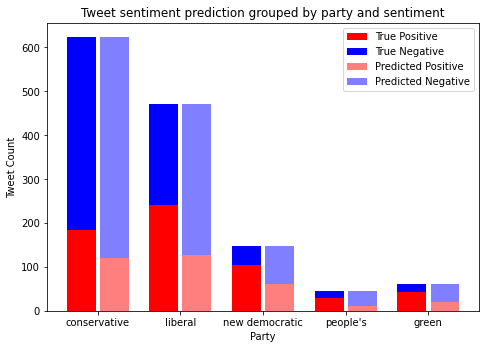

In [41]:
#visualize the predicted sentiment vs. the real sentiment for each party
pred_sentiment_df = election_text_df['party'].to_frame()
pred_sentiment_df['predicted_sentiment'] = election_pred
pred_sentiment_df['true_sentiment'] = election_sentiment_label


true_positive = (pred_sentiment_df.loc[pred_sentiment_df['party']=='conservative']['true_sentiment'].sum(),
pred_sentiment_df.loc[pred_sentiment_df['party']=='liberal']['true_sentiment'].sum(),
pred_sentiment_df.loc[pred_sentiment_df['party']=='new democratic']['true_sentiment'].sum(),
pred_sentiment_df.loc[pred_sentiment_df['party']=='peoples']['true_sentiment'].sum(),
pred_sentiment_df.loc[pred_sentiment_df['party']=='green']['true_sentiment'].sum())

true_negative = (pred_sentiment_df.loc[pred_sentiment_df['party']=='conservative']['party'].count()-pred_sentiment_df.loc[pred_sentiment_df['party']=='conservative']['true_sentiment'].sum(),
                        pred_sentiment_df.loc[pred_sentiment_df['party']=='liberal']['party'].count()-pred_sentiment_df.loc[pred_sentiment_df['party']=='liberal']['true_sentiment'].sum(),
                        pred_sentiment_df.loc[pred_sentiment_df['party']=='new democratic']['party'].count()-pred_sentiment_df.loc[pred_sentiment_df['party']=='new democratic']['true_sentiment'].sum(),
                        pred_sentiment_df.loc[pred_sentiment_df['party']=='peoples']['party'].count()-pred_sentiment_df.loc[pred_sentiment_df['party']=='peoples']['true_sentiment'].sum(),
                        pred_sentiment_df.loc[pred_sentiment_df['party']=='green']['party'].count()-pred_sentiment_df.loc[pred_sentiment_df['party']=='green']['true_sentiment'].sum())

pred_positive = (pred_sentiment_df.loc[pred_sentiment_df['party']=='conservative']['predicted_sentiment'].sum(),
pred_sentiment_df.loc[pred_sentiment_df['party']=='liberal']['predicted_sentiment'].sum(),
pred_sentiment_df.loc[pred_sentiment_df['party']=='new democratic']['predicted_sentiment'].sum(),
pred_sentiment_df.loc[pred_sentiment_df['party']=='peoples']['predicted_sentiment'].sum(),
pred_sentiment_df.loc[pred_sentiment_df['party']=='green']['predicted_sentiment'].sum())

pred_negative = (pred_sentiment_df.loc[pred_sentiment_df['party']=='conservative']['party'].count()-pred_sentiment_df.loc[pred_sentiment_df['party']=='conservative']['predicted_sentiment'].sum(),
                        pred_sentiment_df.loc[pred_sentiment_df['party']=='liberal']['party'].count()-pred_sentiment_df.loc[pred_sentiment_df['party']=='liberal']['predicted_sentiment'].sum(),
                        pred_sentiment_df.loc[pred_sentiment_df['party']=='new democratic']['party'].count()-pred_sentiment_df.loc[pred_sentiment_df['party']=='new democratic']['predicted_sentiment'].sum(),
                        pred_sentiment_df.loc[pred_sentiment_df['party']=='peoples']['party'].count()-pred_sentiment_df.loc[pred_sentiment_df['party']=='peoples']['predicted_sentiment'].sum(),
                        pred_sentiment_df.loc[pred_sentiment_df['party']=='green']['party'].count()-pred_sentiment_df.loc[pred_sentiment_df['party']=='green']['predicted_sentiment'].sum())


N = 5
ind = np.arange(N) # the x locations for the groups
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(ind, true_positive, width, color='r')
ax.bar(ind, true_negative, width,bottom=true_positive, color='b')
ax.bar(ind + 0.4, pred_positive, width, color='r', alpha=0.5)
ax.bar(ind + 0.4, pred_negative, width,bottom=pred_positive, color='b', alpha=0.5)

ax.set_ylabel('Tweet Count')
ax.set_xlabel('Party')
ax.set_title('Tweet sentiment prediction grouped by party and sentiment')
ax.set_xticks(ind+0.2)
ax.set_xticklabels(('conservative', 'liberal', 'new democratic', "people's", 'green'))
ax.legend(labels=['True Positive', 'True Negative', 'Predicted Positive', 'Predicted Negative'])
plt.show()

The best model tested on the generic tweets is Logistic Regression with Bag of Words Encoding, it has F1 score of 97.9% and accuracy of 97.0%

When applied to the election dataset, the best model only has F1 score of 53% and accuracy of 62.3%, which is not much better than a random selection (accuracy of 50%)

The predictions are overly negative for all parties, as shown on the graph

It would seem that using generic tweets to train model does not help much to predict the sentiments in the election tweets


# Negative Reasons Prediction Models

In [42]:
#choosing the negative tweets and reasons from the cleaned election text
election_negative_cleaned_text = clean_election_text[election_df['sentiment'] == 0]
election_negative_reason = election_df.loc[election_df['sentiment'] == 0]['negative_reason']

In [43]:
#split the negative election tweets into 70% train and 30% test
X_train_negative_reason, X_test_negative_reason, y_train_negative_reason, y_test_negative_reason = train_test_split(
    election_negative_cleaned_text, election_negative_reason, test_size=0.3, random_state=42)

## Bag of Words Encoding

In [44]:
#create bag of words encoding
#only fit the vectorizer on the training data from the election tweets
#then transform the train and test data from the election tweets
#check the length of the vocabulary generated
bow_vectorizer_negative_reason = CountVectorizer(max_features=50000)
bow_vectorizer_negative_reason.fit(X_train_negative_reason)

X_train_negative_reason_bow = bow_vectorizer_negative_reason.transform(X_train_negative_reason)
X_test_negative_reason_bow = bow_vectorizer_negative_reason.transform(X_test_negative_reason)

print(f"length of vocabulary is: {len(bow_vectorizer_negative_reason.vocabulary_)}")

length of vocabulary is: 3511


In [45]:
#test models with bag of words encoding
#only accuracy scores is used because it is a multiclass classification
print("Bag of Words Encoding")

#logistic regression
bow_logit_negative_reason = LogisticRegression(max_iter=500).fit(X_train_negative_reason_bow, y_train_negative_reason)
print(f"Logistic regression accuracy: {accuracy_score(y_test_negative_reason,bow_logit_negative_reason.predict(X_test_negative_reason_bow))}")

#complement naive bayes
bow_complementNB_negative_reason = ComplementNB().fit(X_train_negative_reason_bow, y_train_negative_reason)
print(f"Complement naive bayes accuracy: {accuracy_score(y_test_negative_reason,bow_complementNB_negative_reason.predict(X_test_negative_reason_bow))}")

#random forest
bow_randomforest_negative_reason = RandomForestClassifier(max_depth=100,random_state=0).fit(X_train_negative_reason_bow, y_train_negative_reason)
print(f"Random Forest accuracy: {accuracy_score(y_test_negative_reason,bow_randomforest_negative_reason.predict(X_test_negative_reason_bow))}")

Bag of Words Encoding
Logistic regression accuracy: 0.5695364238410596
Complement naive bayes accuracy: 0.47019867549668876
Random Forest accuracy: 0.543046357615894


In [46]:
#Using the random forest model to look at the top 10 feature importance
print("The 10 most important features in bag of words encoding")
print("identified by the Random Forest Algorithm are:\n")
top10_features_bow_neg = bow_randomforest_negative_reason.feature_importances_.argsort()[-10:][::-1]
for i in top10_features_bow_neg:
    print(bow_vectorizer_negative_reason.get_feature_names()[i], bow_randomforest_negative_reason.feature_importances_[i])

The 10 most important features in bag of words encoding
identified by the Random Forest Algorithm are:

lies 0.026995311727810733
lie 0.011830071437434926
climate 0.01118685130546484
hired 0.01004236064547827
abortion 0.008641765358274588
kinsella 0.008576086433301978
scandal 0.0076268499941165024
lying 0.006525589675879866
say 0.006411344949676818
pay 0.006272246112558469


High importance features are words that are indicative of the negative reasoning

“Lie”, “lies” and “lying” correspond to the reason “Tell Lies”

“Scandal” and “Kinsella” corresponds to the reason “Scandal”

“Climate” corresponds to the reason “Climate Problem”

“Abortion” corresponds to the reason “Woman Reproductive right and Racism”


## TD-IDF Encoding

In [47]:
#create TF-IDF encoding
#only fit the vectorizer on the training data from the election tweets
#then transform the train and test data from the election tweets
#check the length of the vocabulary generated
tfidf_vectorizer_negative_reason = TfidfVectorizer(max_features=50000)
tfidf_vectorizer_negative_reason.fit(X_train_negative_reason)

X_train_negative_reason_tfidf = tfidf_vectorizer_negative_reason.transform(X_train_negative_reason)
X_test_negative_reason_tfidf = tfidf_vectorizer_negative_reason.transform(X_test_negative_reason)

print(f"length of vocabulary is: {len(tfidf_vectorizer_negative_reason.vocabulary_)}")

length of vocabulary is: 3511


In [48]:
#test models with TF-IDF encoding
#only accuracy scores is used because it is a multiclass classification problem
print("TF-IDF Encoding")

#logistic regression
tfidf_logit_negative_reason = LogisticRegression(max_iter=500).fit(X_train_negative_reason_tfidf, y_train_negative_reason)
print(f"Logistic regression accuracy: {accuracy_score(y_test_negative_reason,tfidf_logit_negative_reason.predict(X_test_negative_reason_tfidf))}")

#complement naive bayes
tfidf_complementNB_negative_reason = ComplementNB().fit(X_train_negative_reason_tfidf, y_train_negative_reason)
print(f"Complement naive bayes accuracy: {accuracy_score(y_test_negative_reason,tfidf_complementNB_negative_reason.predict(X_test_negative_reason_tfidf))}")

#random forest
tfidf_randomforest_negative_reason = RandomForestClassifier(max_depth=100,random_state=0).fit(X_train_negative_reason_tfidf, y_train_negative_reason)
print(f"Random Forest accuracy: {accuracy_score(y_test_negative_reason,tfidf_randomforest_negative_reason.predict(X_test_negative_reason_tfidf))}")

TF-IDF Encoding
Logistic regression accuracy: 0.5066225165562914
Complement naive bayes accuracy: 0.46688741721854304
Random Forest accuracy: 0.5629139072847682


In [49]:
#Using the random forest model to look at the top 10 feature importance
print("The 10 most important features in TF-IDF encoding")
print("identified by the Random Forest Algorithm are:\n")
top10_features_tfidf_neg = tfidf_randomforest_negative_reason.feature_importances_.argsort()[-10:][::-1]
for i in top10_features_tfidf_neg:
    print(tfidf_vectorizer_negative_reason.get_feature_names()[i], tfidf_randomforest_negative_reason.feature_importances_[i])

The 10 most important features in TF-IDF encoding
identified by the Random Forest Algorithm are:

lies 0.02774114496284973
lie 0.013516688183356114
climate 0.013211539551780711
abortion 0.011255117950339028
kinsella 0.010688815469510771
lying 0.009084462214247984
hired 0.00906166633864889
scandal 0.007033333711044307
bernier 0.006605566456898073
pay 0.006402056879108867


##Bigram Encoding with Count Vectorizor

In [50]:
#create bigram bag of "phrase" encoding
#only fit the vectorizer on the training data from the election tweets
#then transform the train and test data from the election tweets
#check the length of the vocabulary generated
bigram_vectorizer_negative_reason = CountVectorizer(max_features=50000, ngram_range=(2,2))
bigram_vectorizer_negative_reason.fit(X_train_negative_reason)

X_train_negative_reason_bigram = bigram_vectorizer_negative_reason.transform(X_train_negative_reason)
X_test_negative_reason_bigram = bigram_vectorizer_negative_reason.transform(X_test_negative_reason)

print(f"length of vocabulary is: {len(bigram_vectorizer_negative_reason.vocabulary_)}")

length of vocabulary is: 8093


In [51]:
#take a look at the vocabulary, we can see two words are grouped together as a feature
#thus "bigram"
bigram_vectorizer_negative_reason.vocabulary_

{'time canada': 7134,
 'canada finger': 1006,
 'finger wagging': 2558,
 'wagging preachy': 7663,
 'preachy legacy': 5428,
 'legacy msm': 3744,
 'msm pulled': 4496,
 'pulled heads': 5577,
 'heads already': 3091,
 'already generated': 264,
 'generated massive': 2748,
 'massive public': 4246,
 'public audience': 5564,
 'audience tune': 539,
 'tune turnoff': 7400,
 'turnoff self': 7407,
 'self obsessed': 6352,
 'obsessed know': 4750,
 'know coverage': 3594,
 'yeah come': 8033,
 'come harper': 1356,
 'harper endorsed': 3064,
 'endorsed indian': 2243,
 'indian election': 3328,
 'election endorsing': 2171,
 'endorsing stop': 2258,
 'stop hypocrisy': 6761,
 'choice canadian': 1242,
 'canadian voters': 1046,
 'voters must': 7625,
 'must make': 4520,
 'make election': 4166,
 'election day': 2168,
 'day whether': 1773,
 'whether want': 7823,
 'want someone': 7695,
 'someone investigated': 6596,
 'investigated rcmp': 3412,
 'rcmp obstructing': 5701,
 'obstructing justice': 4751,
 'justice accused'

In [52]:
#test models with bag of words encoding
#only accuracy scores is used because it is a multiclass classification
print("Bigram Encoding")

#logistic regression
bigram_logit_negative_reason = LogisticRegression(max_iter=500).fit(X_train_negative_reason_bigram, y_train_negative_reason)
print(f"Logistic regression accuracy: {accuracy_score(y_test_negative_reason,bigram_logit_negative_reason.predict(X_test_negative_reason_bigram))}")

#complement naive bayes
bigram_complementNB_negative_reason = ComplementNB().fit(X_train_negative_reason_bigram, y_train_negative_reason)
print(f"Complement naive bayes accuracy: {accuracy_score(y_test_negative_reason,bigram_complementNB_negative_reason.predict(X_test_negative_reason_bigram))}")

#random forest
bigram_randomforest_negative_reason = RandomForestClassifier(max_depth=100,random_state=0).fit(X_train_negative_reason_bigram, y_train_negative_reason)
print(f"Random Forest accuracy: {accuracy_score(y_test_negative_reason,bigram_randomforest_negative_reason.predict(X_test_negative_reason_bigram))}")

Bigram Encoding
Logistic regression accuracy: 0.4337748344370861
Complement naive bayes accuracy: 0.23509933774834438
Random Forest accuracy: 0.4304635761589404


In [53]:
#Using the random forest model to look at the top 10 feature importance
print("The 10 most important features in bigram encoding")
print("identified by the Random Forest Algorithm are:\n")
top10_features_bigram = bigram_randomforest_negative_reason.feature_importances_.argsort()[-10:][::-1]
for i in top10_features_bigram:
    print(bigram_vectorizer_negative_reason.get_feature_names()[i], bigram_randomforest_negative_reason.feature_importances_[i])

The 10 most important features in bigram encoding
identified by the Random Forest Algorithm are:

reproductive rights 0.00622397322614705
mae bernier 0.0057509643413957
people party 0.0051152669682321275
abortion debate 0.004923824335365512
seek destroy 0.0043439080287194795
climate change 0.0036641805289570543
destroy people 0.003633378834686225
climate crisis 0.0032058399961549877
scheer say 0.0029031425077283655
hired kinsella 0.0028183436020692908


High importance features are words that are indicative of the negative reasoning

“hired kinsella” likely corresponds to the reason “Scandal”

“climate change”, "climate crisis" likely corresponds to the reason “Climate Problem”

“reproductive rights”, "abortion debate" likely corresponds to the reason “Woman Reproductive right and Racism”

## Tuning Best Model

The best model from above is to use bag of words (word frequency) with logistic regression

In [54]:
from sklearn.model_selection import GridSearchCV

In [55]:
parameters = {'max_iter':[1000],'tol':[0.001],'solver':['saga'],'penalty':('l1','l2'), 'C':[0.01, 0.1, 1, 10, 100]}
clf = GridSearchCV(bow_logit_negative_reason, parameters, cv=3)
clf.fit(X_train_negative_reason_bow, y_train_negative_reason)

GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=500, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'max_iter': [1000],
                         'penalty': ('l1', 'l2'), 'solver': ['saga'],
                         'tol': [0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [56]:
clf.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.001, verbose=0,
                   warm_start=False)

In [57]:
print(f"Best Logistic Regression test accuracy: {accuracy_score(y_test_negative_reason,clf.predict(X_test_negative_reason_bow))}")

Best Logistic Regression test accuracy: 0.6026490066225165


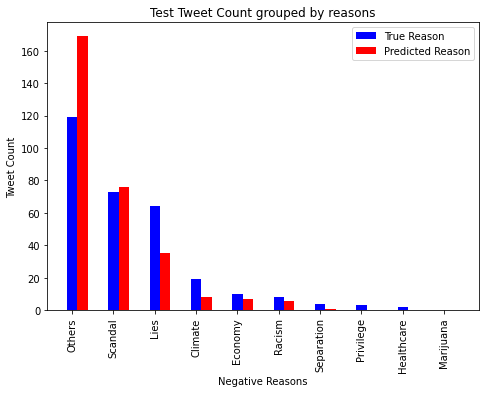

In [58]:
#For the test set in the election dataset
#visualize the distribution of the predictions of negative reasons and the true negative reasons
best_model_result = pd.DataFrame(clf.predict(X_test_negative_reason_bow), columns=['predicted_reason'])
best_model_result['true_reason'] = y_test_negative_reason.values

true_reasons = [best_model_result.loc[best_model_result['true_reason']=='Others']['true_reason'].count(),
                best_model_result.loc[best_model_result['true_reason']=='Scandal']['true_reason'].count(),
                best_model_result.loc[best_model_result['true_reason']=='Tell lies']['true_reason'].count(),
                best_model_result.loc[best_model_result['true_reason']=='Climate Problem']['true_reason'].count(),
                best_model_result.loc[best_model_result['true_reason']=='Economy']['true_reason'].count(),
                best_model_result.loc[best_model_result['true_reason']=='Women Reproductive right and Racism']['true_reason'].count(),
                best_model_result.loc[best_model_result['true_reason']=='Separation']['true_reason'].count(),
                best_model_result.loc[best_model_result['true_reason']=='Privilege']['true_reason'].count(),
                best_model_result.loc[best_model_result['true_reason']=='Healthcare']['true_reason'].count(),
                best_model_result.loc[best_model_result['true_reason']=='Healthcare and Marijuana']['true_reason'].count()]

pred_reasons = [best_model_result.loc[best_model_result['predicted_reason']=='Others']['predicted_reason'].count(),
                best_model_result.loc[best_model_result['predicted_reason']=='Scandal']['predicted_reason'].count(),
                best_model_result.loc[best_model_result['predicted_reason']=='Tell lies']['predicted_reason'].count(),
                best_model_result.loc[best_model_result['predicted_reason']=='Climate Problem']['predicted_reason'].count(),
                best_model_result.loc[best_model_result['predicted_reason']=='Economy']['predicted_reason'].count(),
                best_model_result.loc[best_model_result['predicted_reason']=='Women Reproductive right and Racism']['predicted_reason'].count(),
                best_model_result.loc[best_model_result['predicted_reason']=='Separation']['predicted_reason'].count(),
                best_model_result.loc[best_model_result['predicted_reason']=='Privilege']['predicted_reason'].count(),
                best_model_result.loc[best_model_result['predicted_reason']=='Healthcare']['predicted_reason'].count(),
                best_model_result.loc[best_model_result['predicted_reason']=='Healthcare and Marijuana']['predicted_reason'].count()]

X = np.arange(10)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, true_reasons, color = 'b', width = 0.25)
ax.bar(X + 0.25, pred_reasons, color = 'r', width = 0.25)

ax.set_ylabel('Tweet Count')
ax.set_title('Test Tweet Count grouped by reasons')
ax.set_xlabel('Negative Reasons')
ax.set_xticks(X)
ax.set_xticklabels(('Others','Scandal','Lies','Climate','Economy','Racism','Separation','Privilege','Healthcare','Marijuana'),rotation=90)
ax.legend(labels=['True Reason', 'Predicted Reason'])
plt.show()

The best model tested is Logistic Regression with Bag of Words Encoding, it has test accuracy of 57.0%

After hyperparameter tuning, the test accuracy increased to 60.3%

The predicted reasons are mostly in “Others” section. 

Some of the reasons are not being predicted because they have very little samples, such as “Health care and Marijuana”

Class imbalance might be a factor


# Discussion

**Model for Predicting Sentiment of Election Tweet**

There is a huge difference between training and testing F1 score, suggesting the model could be severely overfitting the training set, and also the two dataset are significantly different than each other. This can be explained because people are likely talking about politics differently than how they normally talk on social media. The text patterns appear to be less sentimental, and using more sentiment neutral words, which makes the prediction harder.

The predicted sentiments are overly negative for every party. When words are taken out of context, political sentiment is hard to analyse, people might be sarcastic, or trying to make suggestions by listing negative points, which could all be possible reasons for a positive tweet being predicted as negative. 

Overall, using generic training material is not very useful for analysing political content because the two uses very different words, political tweets are much more complex to digest than regular tweets

To improve accuracy of the model, it is best to use texts that are more about politics for model training, the model should perform better if it can learn what features are more important in the context of political opinion. Model hyperparameter tuning could also help to increase the accuracy, although the improvement might be minor.

**Model for Predict Reasons for Negative Election Tweet**

The best model has a test accuracy of 57.0%, the hyperparameter tuning improved the accuracy to 60.3%. Some reasons that the model is not functioning better is that for some categories, there are significantly less samples than other categories, such as “Healthcare and Marijuana”. Therefore, without the key features related to these categories, the model is less likely to predict them and more likely to predict other categories with more samples, such as “Others”.

Reasons with more keywords would be relatively easier to predict, as show in the result, the model predicts the “Scandal” category pretty well. This is because there are quite a few keywords related to “Scandal”. Such as “black face” for the liberal party, and “kinsella” for the conservative party 
To improve the model, we can bootstrap the training samples so that each of the categories have similar amount of tweets. Getting a larger dataset also helps for building more vocabulary for some categories with little samples.

**In conclusion**

Although the models do not exhibit strong prediction accuracy, knowing the public sentiment towards each party does help with knowing the Candian political landscape. Through our analysis, we know that the most popular parties are the conservative party and the liberal party, The public sentiment on twitter is more negative towards the conservative party than the liberal party. In fact, the liberal party did win the 2019 election, meaning there is value in the sentiments people demonstrate on social media platforms such as twitter.
